In [8]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import sys, os
sys.path.append(os.path.abspath(".."))
from configs import GOOGLE_APPLICATION_CREDENTIALS
from google.cloud import bigquery

In [9]:
client = bigquery.Client.from_service_account_json(GOOGLE_APPLICATION_CREDENTIALS)

In [42]:
query = "SELECT * " \
"FROM `khangtestdbt.xecupredict.bonbanh_com` "
data_bonbanh = client.query(query).to_dataframe()

data_bonbanh.head()

,Name,Năm_sản_xuất,Tình_trạng,Số_Km_đã_đi,Xuất_xứ,Kiểu_dáng,Động_cơ,Màu_ngoại_thất,Màu_nội_thất
0,Xe \n\t\t\t\n\t\t\t\t\t\t\tVinFast VF3 \n\t\t\...,2025,Xe mới,None,Lắp ráp trong nước,SUV,Điện,Hồng,Đen
1,Xe \n\t\t\t\n\t\t\t\t\t\t\tVinFast VF3 \n\t\t\...,2024,Xe đã dùng,"22,000 Km",Lắp ráp trong nước,Hatchback,Điện,Xám,Nhiều màu
2,Xe \n\t\t\t\n\t\t\t\t\t\t\tVinFast VF3 \n\t\t\...,2024,Xe đã dùng,"10,012 Km",Lắp ráp trong nước,Hatchback,Điện,Xám,Nhiều màu
3,Xe \n\t\t\t\n\t\t\t\t\t\t\tVinFast VF3 \n\t\t\...,2024,Xe đã dùng,"10,000 Km",Lắp ráp trong nước,Hatchback,Điện,Vàng,Nhiều màu
4,Xe \n\t\t\t\n\t\t\t\t\t\t\tVinFast VF3 \n\t\t\...,2025,Xe mới,None,Lắp ráp trong nước,Hatchback,Điện,Xanh,Đen


In [140]:
df_bonbanh = data_bonbanh.copy()

In [141]:
df_bonbanh.columns

Index(['Name', 'Năm_sản_xuất', 'Tình_trạng', 'Số_Km_đã_đi', 'Xuất_xứ',
       'Kiểu_dáng', 'Động_cơ', 'Màu_ngoại_thất', 'Màu_nội_thất'],
      dtype='object')

In [142]:
df_bonbanh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            3000 non-null   object
 1   Năm_sản_xuất    3000 non-null   object
 2   Tình_trạng      3000 non-null   object
 3   Số_Km_đã_đi     2433 non-null   object
 4   Xuất_xứ         3000 non-null   object
 5   Kiểu_dáng       3000 non-null   object
 6   Động_cơ         3000 non-null   object
 7   Màu_ngoại_thất  3000 non-null   object
 8   Màu_nội_thất    3000 non-null   object
dtypes: object(9)
memory usage: 211.1+ KB


In [143]:
import re

def clean_name(text):
    if not isinstance(text, str):
        return None
    
    text = re.sub(r"^\s*Xe\s+", "", text, flags=re.IGNORECASE)
    
    text = re.sub(r"[^a-zA-Z0-9À-ỹ\s]", " ", text)
    
    text = re.sub(r"\s+", " ", text)
    
    return text.strip()

In [144]:
df_bonbanh["Name"] = df_bonbanh["Name"].apply(clean_name)

In [145]:
def split_name_price(full_name):
    if not isinstance(full_name, str):
        return None, None
    
    words = full_name.strip().split()
    if len(words) >= 2:
        price_raw = " ".join(words[-2:]).lower()
        car = " ".join(words[:-2]).strip()
        return car, price_raw
    else:
        return full_name, None


In [146]:
def extract_price(name_str):
    if not isinstance(name_str, str):
        return None

    name_str = name_str.strip()
    
    match = re.search(r'(\d+(\.\d+)?\s*t[ỷi](?:\s*\d+\s*triệu)?)|(\d+(\.\d+)?\s*triệu)', name_str, re.IGNORECASE)
    if match:
        return match.group(0)
    return None

In [147]:
df_bonbanh['Price'] = df_bonbanh['Name'].apply(extract_price)

In [148]:
df_bonbanh["brand"] = df_bonbanh["Name"].str.strip().str.split().str[0]

In [149]:
df_bonbanh["brand"].unique()

array(['VinFast', 'Volkswagen', 'Volvo', 'Toyota', 'Mazda', 'Mercedes',
       'Lexus', 'Lynk', 'MG', 'Isuzu', 'Jaguar', 'Jeep', 'Kia',
       'LandRover', 'Lamborghini', 'Hyundai', 'Infiniti', 'Mitsubishi',
       'Mini', 'Peugeot', 'Porsche', 'RAM', 'Rolls', 'Smart', 'Ssangyong',
       'Subaru', 'Suzuki', 'Morgan', 'Nissan', 'Omoda', 'Ford', 'GAC',
       'Gaz', 'Haval', 'Honda', 'BMW', 'Chevrolet', 'Citroen', 'Daewoo',
       'Daihatsu', 'Dodge', 'Dongfeng', 'Ferrari', 'BYD', 'Cadillac',
       'Chenglong', 'Audi', 'Bentley', 'Bestune'], dtype=object)

In [150]:
def cv_price(price_str):
    if not isinstance(price_str, str):
        return None

    price_str = price_str.strip().lower()
    total = 0

    ty_match = re.search(r'(\d+(\.\d+)?)\s*t[ỷi]', price_str)
    if ty_match:
        ty = float(ty_match.group(1))
        total += int(ty * 1_000_000_000)

    trieu_match = re.search(r'(\d+(\.\d+)?)\s*triệu', price_str)
    if trieu_match:
        trieu = float(trieu_match.group(1))
        total += int(trieu * 1_000_000)

    return total if total > 0 else None


In [151]:
df_bonbanh["Price"] = df_bonbanh["Price"].apply(cv_price)

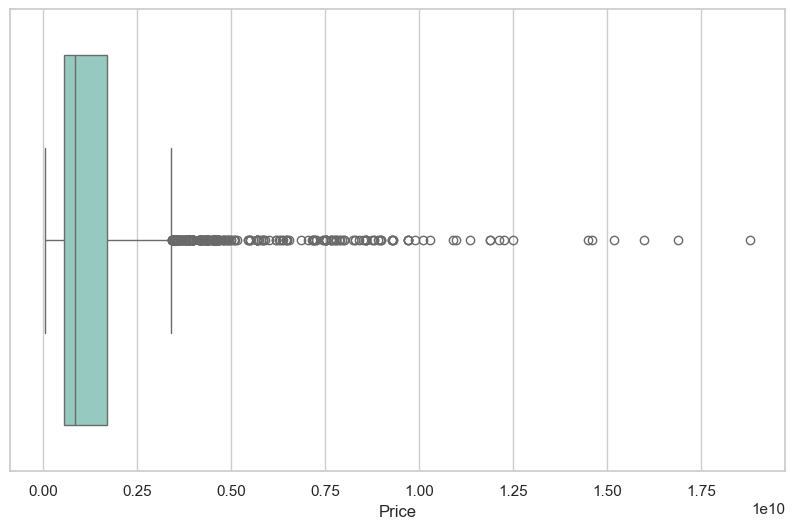

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid") 

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="Price",
    data=df_bonbanh,
    palette="Set3"  
)
plt.show()


In [156]:
cheapest_5 = df_bonbanh.nsmallest(5, 'Price')
cheapest_5


,Name,Năm_sản_xuất,Tình_trạng,Số_Km_đã_đi,Xuất_xứ,Kiểu_dáng,Động_cơ,Màu_ngoại_thất,Màu_nội_thất,Price,brand
2649,Chevrolet Spark Van 0 8 MT 2011 54 Triệu,2011,Xe đã dùng,"27,000 Km",Lắp ráp trong nước,Van/Minivan,Xăng 0.8 L,Bạc,Bạc,54000000.0,Chevrolet
896,Mazda 323 Classic GLX 2003 73 Triệu,2003,Xe đã dùng,"150,000 Km",Lắp ráp trong nước,Sedan,Xăng 1.6 L,Bạc,Kem,73000000.0,Mazda
1746,Toyota Vios 1 5 MT 2006 89 Triệu,2006,Xe đã dùng,0 Km,Lắp ráp trong nước,Sedan,Xăng 1.5 L,Đen,Nhiều màu,89000000.0,Toyota
380,Mazda Premacy 1 8 AT 2003 92 Triệu,2003,Xe đã dùng,"180,000 Km",Lắp ráp trong nước,Crossover,Xăng 1.8 L,Xanh,Kem,92000000.0,Mazda
2505,Daihatsu Charade 1 0 AT 2006 99 Triệu,2006,Xe đã dùng,"11,000 Km",Nhập khẩu,Hatchback,Xăng 1.0 L,Bạc,Kem,99000000.0,Daihatsu


In [157]:
most_expensive_5 = df_bonbanh.nlargest(5, 'Price')
most_expensive_5


,Name,Năm_sản_xuất,Tình_trạng,Số_Km_đã_đi,Xuất_xứ,Kiểu_dáng,Động_cơ,Màu_ngoại_thất,Màu_nội_thất,Price,brand
2509,Ferrari 296 GTB 2022 18 Tỷ 800 Triệu,2022,Xe đã dùng,0 Km,Nhập khẩu,Coupe,Xăng 3.0 L,Vàng,Đen,1.880000e+10,Ferrari
1181,Lamborghini Aventador LP 700 4 2015 16 Tỷ 900 ...,2015,Xe đã dùng,"20,000 Km",Nhập khẩu,Coupe,Xăng 6.5 L,Vàng,Đen,1.690000e+10,Lamborghini
837,Mercedes Benz Maybach S680 4Matic 2024 15 Tỷ 9...,2024,Xe mới,None,Nhập khẩu,Sedan,Xăng 6.0 L,Đen,Kem,1.599000e+10,Mercedes
836,Mercedes Benz Maybach S680 4Matic 2024 15 Tỷ 1...,2024,Xe mới,None,Nhập khẩu,Sedan,Xăng 6.0 L,Đen,Kem,1.519900e+10,Mercedes
1107,LandRover Range Rover Autobiography LWB P460e ...,2025,Xe đã dùng,"2,200 Km",Nhập khẩu,SUV,Hybrid 3.0 L,Đen,Nâu,1.459000e+10,LandRover


In [158]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()
    return df_filtered


In [159]:
df_bonbanh = remove_outliers_iqr(df_bonbanh, 'Price')

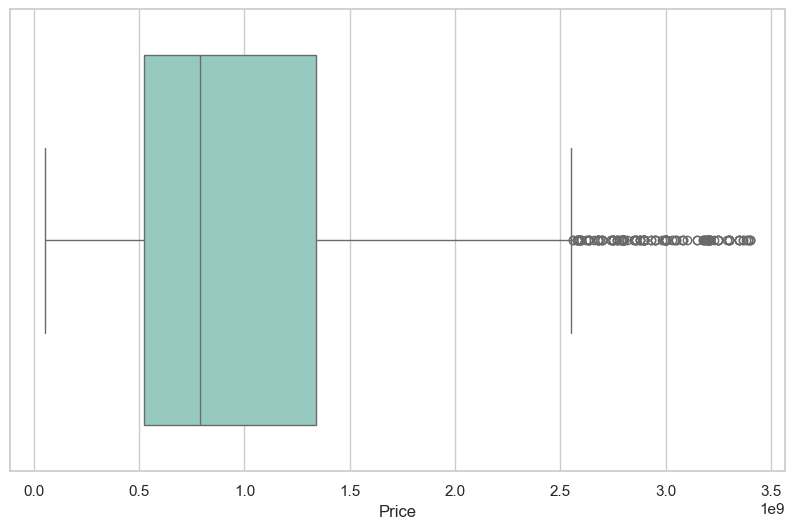

In [160]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="Price",
    data=df_bonbanh,
    palette="Set3"  
)
plt.show()